# CS 6220 Data Mining --- Final project

Analysis on Global Warming

-- [Sub-project] analyze the Global Carbon Budget

Student: Ying Bi

## Summary
For this task, we want to analyze and predict about the Global Carbon Budget change.

Here are the list of items of the report:
- Track the fossil emission changes in the past 60 years.

### Track the fossil emission changes in the past 60 years.
We created the GIF picture to track every category change in the past 60 years. After checking the change for the last past 60 years, we found the fossil emission from the Oil is larger than the Coal before 2003. After 2003, the emission from the Coal is the largest source.

In [15]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML
HTML('<img src="Image/Category.gif" width="750" align="center">')

### Check and show the plot about the historical Budget
For this task, we want to create the plot and show the all source of emissions and sinks.

In [16]:
import csv
import numpy as np

def load_dataset(filename):
    '''Loads an example of market basket transactions from a provided csv file.

    Returns: A list (database) of lists (transactions). Each element of a transaction is 
    an item.
    '''

    with open(filename,'r') as dest_f:
        data_iter = csv.reader(dest_f, delimiter = ',', quotechar = '"')
        data = [data for data in data_iter]
        data_array = np.asarray(data)
        
    return data_array

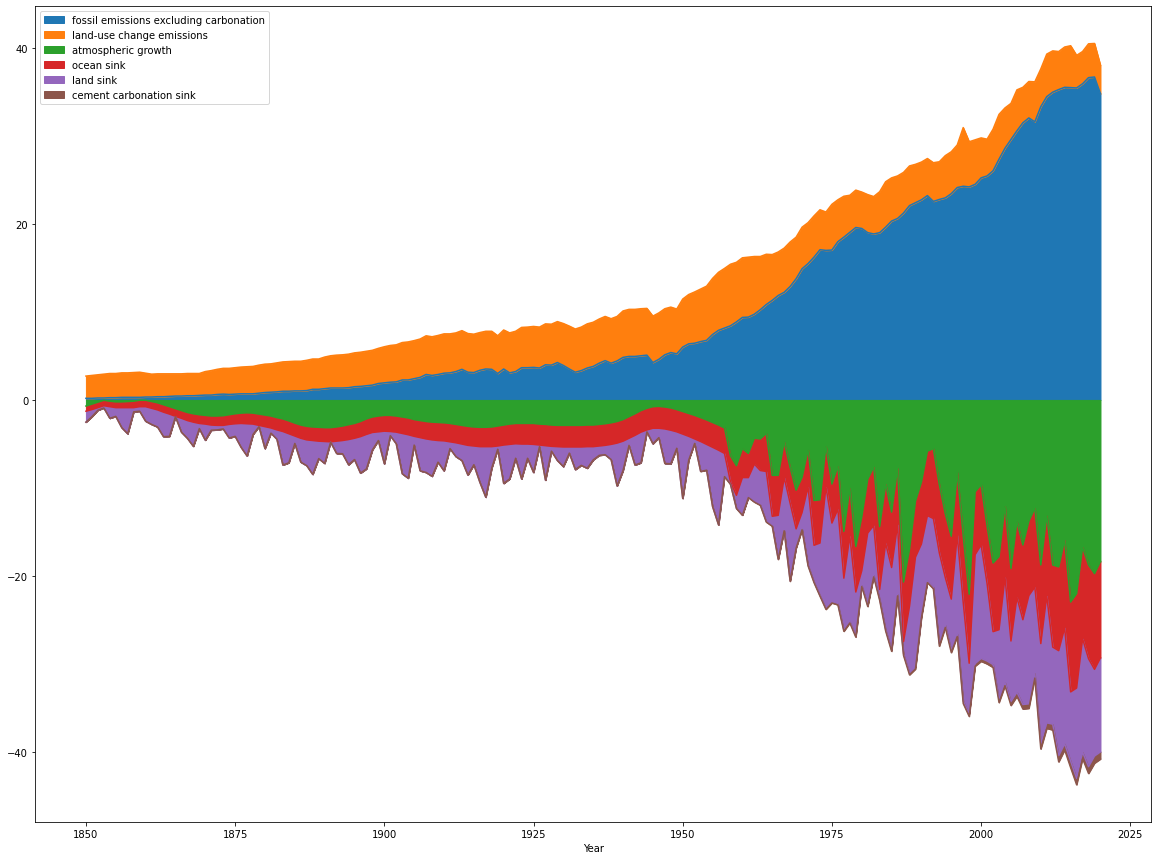

In [17]:
import pandas as pd

global_carbon_budget = load_dataset("Data/CarbonBudget/Historical_Budget.csv")
dataset = global_carbon_budget[1:].astype(np.float)

global_carbon_budget_pd = pd.DataFrame(dataset, columns = global_carbon_budget[0])
global_carbon_budget_pd = global_carbon_budget_pd.set_index(global_carbon_budget_pd.iloc[:,0])
global_carbon_budget_pd = global_carbon_budget_pd.iloc[:, 1:]
cols = global_carbon_budget_pd.columns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

if 'budget imbalance' in global_carbon_budget_pd:
    del global_carbon_budget_pd['budget imbalance']

# Convert the billion tonnes of Carbon to Carbon dioxide (* 3.664)
global_carbon_budget_pd['fossil emissions excluding carbonation'] = abs(global_carbon_budget_pd['fossil emissions excluding carbonation']) * (3.664)
global_carbon_budget_pd['land-use change emissions'] = abs(global_carbon_budget_pd['land-use change emissions']) * (3.664)
global_carbon_budget_pd['atmospheric growth'] = abs(global_carbon_budget_pd['atmospheric growth']) * (-3.664)
global_carbon_budget_pd['land sink'] = abs(global_carbon_budget_pd['land sink']) * (-3.664)
global_carbon_budget_pd['ocean sink'] = abs(global_carbon_budget_pd['ocean sink']) * (-3.664)
global_carbon_budget_pd['cement carbonation sink'] = abs(global_carbon_budget_pd['cement carbonation sink']) * (-3.664)

fig = global_carbon_budget_pd.plot.area(stacked=True, figsize=(20,15))
plt.show()

### Check the relationship between all of the variables.
After this check, we found the covariance between the fossil emissions and (atmospheric growth/ocean sink/land sink) is near the minus one, so they should have the strong relationship. We can use the linear regression method to find their relation and we can use the model to predict the values. However, the land-use change emissions is not related to the other varaibles. After checking all of the values, I think the land-use change emission is a constant variable. 

In [18]:
global_carbon_budget_pd.corr()

,fossil emissions excluding carbonation,land-use change emissions,atmospheric growth,ocean sink,land sink,cement carbonation sink
fossil emissions excluding carbonation,1.000000,0.273553,-0.927739,-0.989492,-0.832884,-0.934408
land-use change emissions,0.273553,1.000000,-0.215243,-0.296101,-0.223694,-0.079190
atmospheric growth,-0.927739,-0.215243,1.000000,0.924360,0.677340,0.867398
ocean sink,-0.989492,-0.296101,0.924360,1.000000,0.808396,0.926675
land sink,-0.832884,-0.223694,0.677340,0.808396,1.000000,0.771209
cement carbonation sink,-0.934408,-0.079190,0.867398,0.926675,0.771209,1.000000


### Train the models with four linear models.

In [19]:
from sklearn import linear_model

model_atmospheric = linear_model.LinearRegression()
model_atmospheric.fit(global_carbon_budget_pd[['fossil emissions excluding carbonation']], global_carbon_budget_pd['atmospheric growth'])

model_land = linear_model.LinearRegression()
model_land.fit(global_carbon_budget_pd[['fossil emissions excluding carbonation']], global_carbon_budget_pd['land sink'])

model_ocean = linear_model.LinearRegression()
model_ocean.fit(global_carbon_budget_pd[['fossil emissions excluding carbonation']], global_carbon_budget_pd['ocean sink'])

model_cement = linear_model.LinearRegression()
model_cement.fit(global_carbon_budget_pd[['fossil emissions excluding carbonation']], global_carbon_budget_pd['cement carbonation sink'])

LinearRegression()

In [20]:
global_carbon_budget_predict = global_carbon_budget_pd.copy()
global_carbon_budget_predict['predicted fossil emissions excluding carbonation'] = 0
global_carbon_budget_predict['predicted land-use change emissions'] = 0
global_carbon_budget_predict['predicted atmospheric growth'] = 0
global_carbon_budget_predict['predicted ocean sink'] = 0
global_carbon_budget_predict['predicted land sink'] = 0
global_carbon_budget_predict['predicted cement carbonation sink'] = 0

### Predict the information with the models

We load the the 1.5_Mitigation_Curves_Data from the team project. We used our trained model to predict all of the information including the atmospheric growth, ocean sink, land sink and cement carbonation sink. We also create the plot for the predicting data.

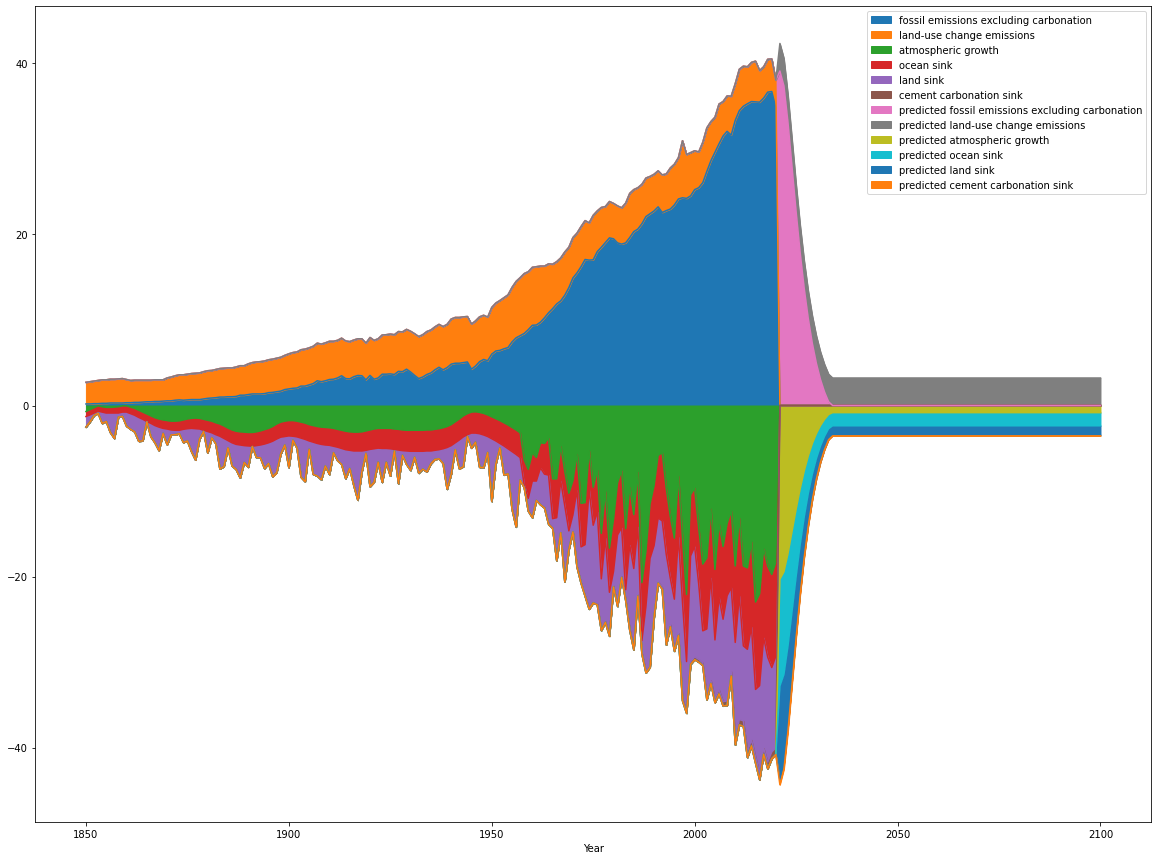

In [21]:
mitigation = load_dataset("Data/VisualizationData/1.5_Mitigation_Curves_Data.csv")
dataset = mitigation[1:]

result = pd.DataFrame(dataset, columns = mitigation[0])
result = result.set_index(result.iloc[:,1])
result = result.iloc[:, 2:]
predicted_2021 = pd.DataFrame(result, columns=['2021'])

for year in range(2021, 2101):
    co2_num = max(float(predicted_2021.loc[str(year)]['2021']) - 3.22, 0)
    co2 = np.array([co2_num]).reshape((-1, 1))
    
    predicted_list = [0,0,0,0,0,0, co2_num, 3.22, model_atmospheric.predict(co2)[0],model_land.predict(co2)[0],model_ocean.predict(co2)[0],abs(model_cement.predict(co2)[0]) * -1]
    global_carbon_budget_predict.loc[float(year)] = predicted_list

fig = global_carbon_budget_predict.plot.area(stacked=True, figsize=(20,15))
plt.show()